In [128]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import glob

In [20]:
ten_epochs = glob.glob('../logging/20-02-2024_2213/*_train_val_summary',recursive=True)
ten_epochs_2 = glob.glob('../logging/21-02-2024_0846/*_train_val_summary',recursive=True)
twenty_epochs = [*ten_epochs,*ten_epochs_2]

In [84]:
output_list = ['Function','Role','Level']
epoch_stats = []
loss_training = []
loss_validation = []
accuracy_training = {}
accuracy_validation = {}
for output in output_list:
    accuracy_training[output] = []
    accuracy_validation[output] = []
for epoch_path in twenty_epochs:
    with open(epoch_path,'rb') as file:
        this_file = pickle.load(file)
        epoch_stats.append(this_file[-1])
        loss_training.append(this_file[-1]['training_loss'])
        loss_validation.append(this_file[-1]['validation_loss'])
        for output in output_list:
            accuracy_training[output].append(this_file[-1]['training_accuracy'][output])
            accuracy_validation[output].append(this_file[-1]['validation_accuracy'][output])

for output in output_list:
    accuracy_training[output] = np.array(accuracy_training[output])
    accuracy_validation[output] = np.array(accuracy_validation[output])
loss_training = np.array(loss_training)
loss_validation = np.array(loss_validation)
epochs = np.arange(1,21,1)

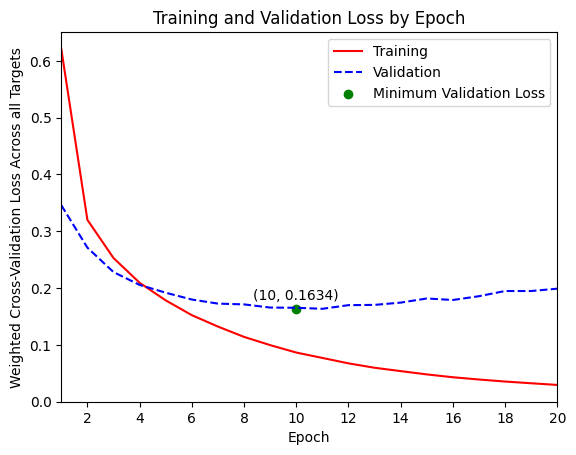

In [85]:
min_epoch = loss_validation.argmin()
min_val = loss_validation.min()
f,ax = plt.subplots()
ax.plot(epochs,loss_training, label = 'Training',linestyle = '-',color = 'red')
ax.plot(epochs,loss_validation, label = 'Validation',linestyle = '--',color = 'blue')
plt.xlim(epochs.min(),epochs.max())
ax.set_xticks(np.arange(2,21,2))
ax.scatter(min_epoch,min_val,
           label = 'Minimum Validation Loss'.format(min_val),color = 'green')
ax.text(min_epoch,min_val+.01,'({:.0f}, {:.4f})'.format(min_epoch,min_val),
        horizontalalignment = 'center',verticalalignment = 'bottom')
ax.set_title('Training and Validation Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Weighted Cross-Validation Loss Across all Targets')
ax.legend()

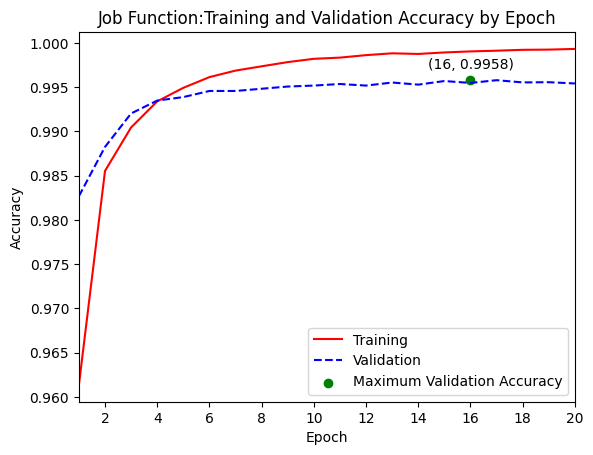

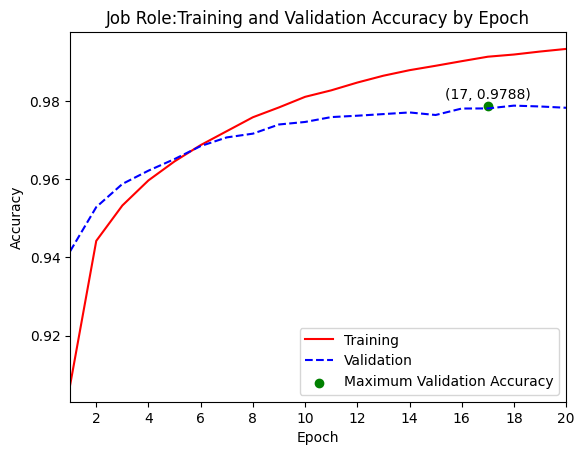

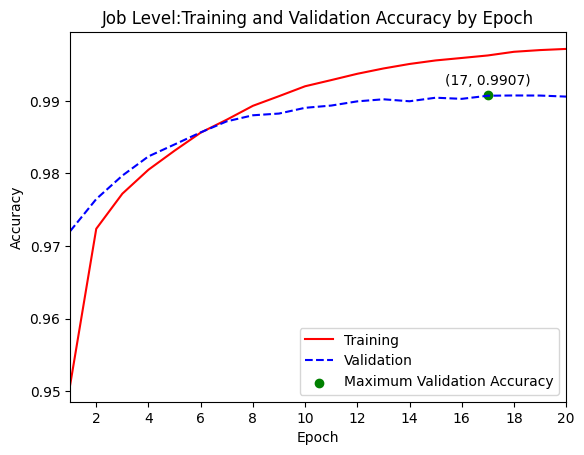

In [86]:
for output in output_list:
        min_epoch = accuracy_validation[output].argmax()
        min_val = accuracy_validation[output].max()
        f,ax = plt.subplots()
        ax.plot(epochs,accuracy_training[output], label = 'Training',linestyle = '-',color = 'red')
        ax.plot(epochs,accuracy_validation[output], label = 'Validation',linestyle = '--',color = 'blue')
        plt.xlim(epochs.min(),epochs.max())
        ax.set_xticks(np.arange(2,21,2))
        ax.scatter(min_epoch,min_val,
                label = 'Maximum Validation Accuracy'.format(min_val),color = 'green')
        ax.text(min_epoch,min_val+.001,'({:.0f}, {:.4f})'.format(min_epoch,min_val),
                horizontalalignment = 'center',verticalalignment = 'bottom')
        ax.set_title('Job {}:Training and Validation Accuracy by Epoch'.format(output))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        ax.legend()

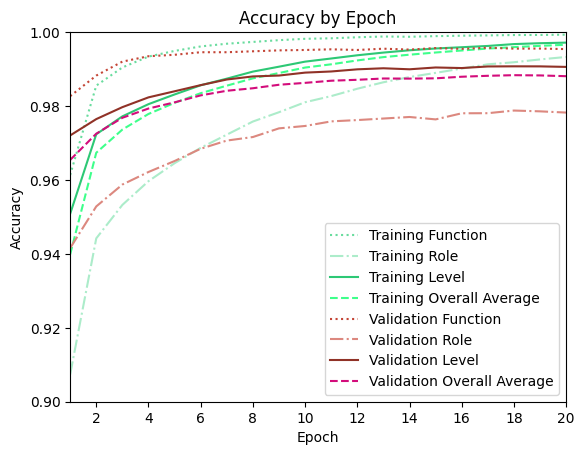

In [116]:
avg_overall_accuracy_training = np.array(list(accuracy_training.values())).mean(axis = 0)
avg_overall_accuracy_validation = np.array(list(accuracy_validation.values())).mean(axis = 0)
f,ax = plt.subplots()
ax.plot(epochs,accuracy_training['Function'], label = 'Training Function',linestyle = 'dotted',color = '#69DC9E')
ax.plot(epochs,accuracy_training['Role'], label = 'Training Role',linestyle = 'dashdot',color = '#ACECCA')
ax.plot(epochs,accuracy_training['Level'], label = 'Training Level',linestyle = '-',color = '#2DC875')
ax.plot(epochs,avg_overall_accuracy_training, label = 'Training Overall Average',linestyle = '--',color = '#3EFF8B')
ax.plot(epochs,accuracy_validation['Function'], label = 'Validation Function',linestyle = 'dotted',color = '#C44536')
ax.plot(epochs,accuracy_validation['Role'], label = 'Validation Role',linestyle = 'dashdot',color = '#DC887F')
ax.plot(epochs,accuracy_validation['Level'], label = 'Validation Level',linestyle = '-',color = '#903227')
ax.plot(epochs,avg_overall_accuracy_validation, label = 'Validation Overall Average',linestyle = '--',color = '#D30C7B')
plt.xlim(epochs.min(),epochs.max())
plt.ylim(0.9,1)
ax.set_xticks(np.arange(2,21,2))
ax.set_title('Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
ax.legend()

In [133]:
with open('../Data/index_label_mapping.pkl','rb') as file:
    index_label_mapping = pickle.load(file)

In [134]:
index_label_mapping

{'Job Role': {0: 'GOVERNANCE RISK COMPLIANCE',
  1: 'INFORMATION SECURITY',
  2: 'IT GENERAL',
  3: 'NETWORKING',
  4: 'NON-ICP',
  5: 'SYSTEMS'},
 'Job Function': {0: 'ENGINEERING',
  1: 'IT',
  2: 'NON-ICP',
  3: 'PROCUREMENT',
  4: 'RISK/LEGAL/COMPLIANCE'},
 'Job Level': {0: 'C-LEVEL',
  1: 'CONTRIBUTOR',
  2: 'DIRECTOR',
  3: 'EXECUTIVE',
  4: 'MANAGER',
  5: 'UNKNOWN'}}

In [171]:
# Looks like validation was misspelled (validtaion). I have fixed in utils.py, but I don't see a need to change this here
conf_mat_labeled = {}
for output in output_list:
    this_mapping = index_label_mapping['Job {}'.format(output)]
    this_df = pd.DataFrame(epoch_stats[min_epoch]['validtaion_conf_mat'][output].numpy().astype(int))
    new_index = [this_mapping[index] for index in this_df.index]
    new_columns = [this_mapping[column] for column in this_df.columns]
    this_df.columns = [["Actual"]*len(new_columns),new_columns]
    this_df.index = [["Predicted"]*len(new_index),new_index]
    conf_mat_labeled[output] = this_df

In [178]:
for output in output_list:
    print('Job {}'.format(output))
    display(conf_mat_labeled[output])
    display(conf_mat_labeled[output].sum().sum())

Job Function


Actual                             \
                                ENGINEERING     IT NON-ICP PROCUREMENT   
Predicted ENGINEERING                  7945     20      38           0   
          IT                             30  58962     148           3   
          NON-ICP                        22     95   16060           0   
          PROCUREMENT                     0      1      11         227   
          RISK/LEGAL/COMPLIANCE           0      1       2           0   

                                                       
                                RISK/LEGAL/COMPLIANCE  
Predicted ENGINEERING                               0  
          IT                                        1  
          NON-ICP                                   3  
          PROCUREMENT                               0  
          RISK/LEGAL/COMPLIANCE                   154

83723

Job Role


Actual  \
                                     GOVERNANCE RISK COMPLIANCE   
Predicted GOVERNANCE RISK COMPLIANCE                       1991   
          INFORMATION SECURITY                               37   
          IT GENERAL                                          6   
          NETWORKING                                          9   
          NON-ICP                                            16   
          SYSTEMS                                             0   

                                                                      \
                                     INFORMATION SECURITY IT GENERAL   
Predicted GOVERNANCE RISK COMPLIANCE                   36         10   
          INFORMATION SECURITY                      26769        191   
          IT GENERAL                                   81       4117   
          NETWORKING                                  152        113   
          NON-ICP                                     111        117   
          SYSTEMS                                      25         29   

                                                                 
                                     NETWORKING NON-ICP SYSTEMS  
Predicted GOVERNANCE RISK COMPLIANCE          4      15       2  
          INFORMATION SECURITY              112     145      31  
          IT GENERAL                         52      62      17  
          NETWORKING                      21397     194      25  
          NON-ICP                           110   26394      39  
          SYSTEMS                            13      25    1276

83723

Job Level


Actual                                               
                      C-LEVEL CONTRIBUTOR DIRECTOR EXECUTIVE MANAGER UNKNOWN
Predicted C-LEVEL        9608          23       12        25       4       5
          CONTRIBUTOR      30       30836       69        41      63      92
          DIRECTOR         10          35    14154        22      15       5
          EXECUTIVE        49          42       28     10873      15      24
          MANAGER          13          75       22         3   17278      19
          UNKNOWN           3          23        1         2       6     198

83723

In [179]:
# Now to pull in the test set
with open('../test/21-02-2024_1954/test_summary','rb') as file:
    test_summary = pickle.load(file)

In [181]:
test_conf_mat_labeled = {}
print('Test Loss: {:.4f}'.format(test_summary['test_loss']))
for output in output_list:
    this_mapping = index_label_mapping['Job {}'.format(output)]
    this_df = pd.DataFrame(test_summary['test_conf_mat'][output].numpy().astype(int))
    new_index = [this_mapping[index] for index in this_df.index]
    new_columns = [this_mapping[column] for column in this_df.columns]
    this_df.columns = [["Actual"]*len(new_columns),new_columns]
    this_df.index = [["Predicted"]*len(new_index),new_index]
    test_conf_mat_labeled[output] = this_df
    print('Job {}'.format(output))
    print('Accuracy: {:.4f}'.format(test_summary['test_accuracy'][output]))
    display(this_df)

Test Loss: 0.1628
Job Function
Accuracy: 0.9961


Actual                             \
                                ENGINEERING     IT NON-ICP PROCUREMENT   
Predicted ENGINEERING                  7833     25      14           0   
          IT                             27  59216     144           1   
          NON-ICP                        20     86   15938           2   
          PROCUREMENT                     1      0       4         257   
          RISK/LEGAL/COMPLIANCE           0      1       0           0   

                                                       
                                RISK/LEGAL/COMPLIANCE  
Predicted ENGINEERING                               1  
          IT                                        1  
          NON-ICP                                   4  
          PROCUREMENT                               0  
          RISK/LEGAL/COMPLIANCE                   149

Job Role
Accuracy: 0.9748


Actual  \
                                     GOVERNANCE RISK COMPLIANCE   
Predicted GOVERNANCE RISK COMPLIANCE                       1969   
          INFORMATION SECURITY                               31   
          IT GENERAL                                          2   
          NETWORKING                                         12   
          NON-ICP                                            16   
          SYSTEMS                                             0   

                                                                      \
                                     INFORMATION SECURITY IT GENERAL   
Predicted GOVERNANCE RISK COMPLIANCE                   65         18   
          INFORMATION SECURITY                      26702        213   
          IT GENERAL                                  102       3912   
          NETWORKING                                  202        158   
          NON-ICP                                     124        136   
          SYSTEMS                                      25         25   

                                                                 
                                     NETWORKING NON-ICP SYSTEMS  
Predicted GOVERNANCE RISK COMPLIANCE         11      15       2  
          INFORMATION SECURITY              116     137      47  
          IT GENERAL                         86      81      25  
          NETWORKING                      21427     238      27  
          NON-ICP                           112   26252      40  
          SYSTEMS                            11      32    1353

Job Level
Accuracy: 0.9887


Actual                                               
                      C-LEVEL CONTRIBUTOR DIRECTOR EXECUTIVE MANAGER UNKNOWN
Predicted C-LEVEL        9623          22       11        31       9       4
          CONTRIBUTOR      18       30615       66        47      63      99
          DIRECTOR         14          85    14049        38      21       8
          EXECUTIVE        60          39       25     10951       7      21
          MANAGER           7         125       18         8   17382      42
          UNKNOWN           4          38        1         8       9     156